#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/27/2017
Updated to use the compound data corrected for extraction efficiency for all compounds.
====
#KL 5/8/2019 Liz wants measured vs. expected for the KEGG integration...make new notebook

In [1]:
if False:
    #this will work to reload whatever I had
    import dill
    dill.load_session('globalsave.pkl')

In [106]:
if True:
    %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [107]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb
from sklearn import preprocessing
#from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler #redundant, fix later

import seaborn as sns

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib_venn import venn2
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [108]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.07.31_v1.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabNames = pd.read_csv(mtabFile,index_col = 'KEGG',usecols = ['KEGG','mtabNames'])
mtabNames.head(3)

,mtabNames
KEGG,
C00196,2-3-dihydroxybenzoic acid
C19675,2-3-dihydroxypropane1sulfonate
C08276,3-mercapto proprionate


In [109]:
#take out the extra columns: 
mtabData.drop(['extEff','mtabNames'],axis = 1,inplace = True)
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])

In [110]:
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,1.500000e-09,0.0,7.560000e-09,0.000000e+00,8.830000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,1.490000e-06,0.0,1.260000e-06,1.700000e-06,3.660000e-08,1.370000e-05,1.170000e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,0.000000e+00,0.0,1.150000e-07,2.140000e-07,0.000000e+00,6.080000e-07,6.060000e-07,1.500000e-09,1.230000e-09,2.170000e-09,1.410000e-10,2.190000e-09


Setup a few useful functions
---

In [111]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [112]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [113]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [114]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [115]:
#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimMap(importString):
    export_trimMap = []
    current_section = None
    for line in importString.rstrip().split("\n"):
        r = line.find('map')
        tp = line[r : r+9]
        export_trimMap.append(tp)
    return export_trimMap

#trim a pathway/compound list
def trimCompounds(cpdString):
    export_trimCpds = []
    current_section = None
    for line in cpdString.rstrip().split("\n"):
        #print(line)
        r = line.find('cpd')
        tp = line[r + 4 : len(line)]
        export_trimCpds.append(tp)
    return export_trimCpds

#make a list....and remove the three digit header bc that will be unique to each strain
def trimPath(pathwayString):
    export_trimPath = []
    current_section = None
    for line in pathwayString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        tp = line[8:13]
        export_trimPath.append(tp)
    return export_trimPath

#make a list....and remove the three digit header bc that will be unique to each strain
def trimGenes(geneString):
    export_trimGenes = []
    current_section = None
    for line in geneString.rstrip().split("\n"):
        #tp = line[5:13] #this includes the three digit species code
        r = line.find('ko:')
        tp = line[r+3 : r+9]
        export_trimGenes.append(tp)
    return export_trimGenes

#trim a reaction list
def trimReactions(rnString):
    export_trimRn = []
    current_section = None
    for line in rnString.rstrip().split("\n"):
        #print(line)
        r = line.find('rn:')
        tp = line[r + 3 : r+9]
        export_trimRn.append(tp)
    return export_trimRn

In [116]:
#bring in the plotting functions
import plotByGroup
#import fxn_plotPathway #with ratios...but other errors in there
import fxn_plotPathway_v2
##if I make a change, have to reload the function(s):
# reload(fxn_plotPathway)

Use the information at KEGG to find the expected overlap across the strains
----

In [ ]:
#need to remember how to do this (5/2019)...start with one compound and find the reactions

In [124]:
#pull the full set of genes for each strain...
pmtGenes = trimGenes(kegg_link("ko","pmt").read())
pmgGenes = trimGenes(kegg_link("ko","pmg").read())
prmGenes = trimGenes(kegg_link("ko","prm").read())

In [104]:
#kegg_get("C00719").read()

In [125]:
#kegg_link("rn","C00719").read()

In [126]:
rnList = kegg_link("reaction","C00719").read()

In [127]:
#setup the strings to match first
rnString = re.compile('(?:[rn:R])(\d+)$') #will return R00190
#cpdString = re.compile('(?:[cpd:C])(\d+)$') #will return C00190
genString = re.compile('(?:[ko:K])(\d+)$') #will return K00190

In [128]:
oneCpd_keepGen = []

test = '\n'
if test != rnList:
    for line in rnList.rstrip().split('\n'):
        #Tracer()()
        m = rnString.search(line) #get the reaction number
        #pmg_countRxn.append(m.group(0))
        genList = kegg_link('ko',m.group(0)).read() #now go get the genes for that reaction
        del m #have to do this so I can pickle the whole thing later...
        #can have no compounds in a reaction (only glycans, begin with G, nothing I have matched)
        if len(genList) > 1: #will be true if cpdList includes compounds
            for line2 in genList.rstrip().split('\n'):
                #Tracer()()
                m2 = genString.search(line2).group(0)
                oneCpd_keepGen.append(m2) 
                #pmg_countGene.append(gen)

In [129]:
oneCpd_keepGen

['K00130',
 'K14085',
 'K00130',
 'K14085',
 'K00544',
 'K13042',
 'K17755',
 'K17755',
 'K18897']

In [131]:
set(oneCpd_keepGen) & set(pmgGenes)

set()

In [132]:
set(oneCpd_keepGen) & set(pmtGenes)

{'K13042'}

In [133]:
set(oneCpd_keepGen) & set(prmGenes)

set()

In [98]:
type(pmg_keepGen)

list

# Get measured compounds 

In [137]:
useCO = mtabPruned.index

In [138]:
#Do the simplest count first, is a compound in anything from each strain?
#match this to the figure from KEGG for the IMBER poster

#slight hack
set_9301 = set()
st = 's9301'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_9301.add(oneCpd)
        
        
set_0801 = set()
st = 's0801'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_0801.add(oneCpd)
        
set_9313 = set()
st = 's9313'
for oneCpd in useCO:
    df2 = mtabPruned.loc[oneCpd].filter(regex = (st))
    r = df2[df2.gt(0)]
    if not r.empty:
        set_9313.add(oneCpd)


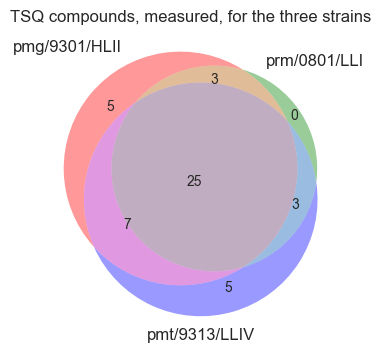

In [139]:
venn3([set_9301,set_0801,set_9313],set_labels = ('pmg/9301/HLII','prm/0801/LLI','pmt/9313/LLIV'))
plt.title('TSQ compounds, measured, for the three strains')
plt.savefig('Pro_TSQmeasured_cpds.png')

# Hack together measured

In [ ]:
#hack, but Liz doesn't like the Venn diagram and wants a list of compounds...export the compounds as 
#KEGG numbers. Because I don't feel up to it, I will manually make this into a list of metabolite names
#4/19/2019

In [56]:
#did this multiple times and opened up next.csv in Excel after each time
import csv

all3 = (set(set_9313) & set(set_0801)) -  set(set_9301)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        
csvfile = "next.csv"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in keep:
        writer.writerow([val])  

In [39]:
#remember - this is the theoretical overlap based on KEGG
all3 = set(pmg_countCpd) & set(prm_countCpd)& set(pmt_countCpd)

keep = []
for item in all3:
    if item in useCO:
        keep.append(item)
        #print(kegg_list(item).read())

In [44]:
for item in cpd_inNstrains.index:
    #first, is it even in this strain?
    if math.isnan(cpd_inNstrains.loc[item,'s9301']):
        pass
    else:
        #is in the list for strain?
        if item in pmg_countCpd:
            pass
        else:
            print(kegg_list(item).read())

cpd:C00719	Betaine; Trimethylaminoacetate; Glycine betaine; N,N,N-Trimethylglycine; Trimethylammonioacetate

cpd:C06767	Hemine; Hemin



In [93]:
import dill
# and to load the session again:
dill.load_session('globalsave.pkl')

In [94]:
# leave debris below here for now, notebook will stop at the 'raise' 
# command here that will keep me from running cells 
# of code that are not meant to be connected
raise

RuntimeError: No active exception to reraise